In [1]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable


# Imports

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time

from pytorch_segmentation.utils.preprocessing import pad_image_even

seed = 42

data_path = "/home/jovyan/work/satellite_data/tmp"
label_path = "data/label_masks/train"
year = 2018#range(2008,2019)
patch_size = [256,256,3] # [x,y,bands]
overlap = 64

padding = False#True

test_ratio = 0.2
val_ratio = 0.2

nworkers = 1

# 1.1 Data Collection

1.1 Data Collection
Label Areas:


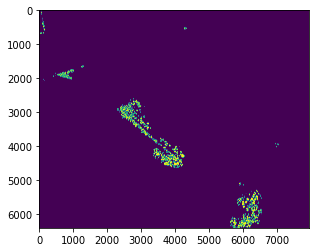

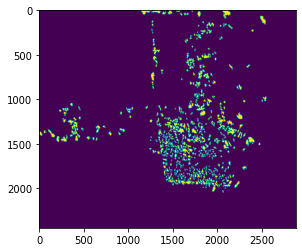

In [2]:

# get label area with export
src_label_nw = rasterio.open("data/label_masks/train/2018_labels_nw_09_03_2022.tif")
src_label_se = rasterio.open("data/label_masks/old/2018_labels_se_09_03_2022_v2.tif")
#TODO Dont forget to close them after !!!!
src_label_read_nw = src_label_nw.read()
src_label_read_se = src_label_se.read()
print("1.1 Data Collection")
print("Label Areas:")
show(src_label_read_nw)
show(src_label_read_se);

# 1.2 Patch Generation
Ensure that the pixel resolution for both files (labels and satellite image) is the same!!!

In [2]:
label_areas = [rasterio.open(os.path.join(label_path,i)) for i in os.listdir(label_path) if i.endswith(".tif")]
satellite_img = rasterio.open(os.path.join(data_path,str(year)+".vrt"))

## Create Label Area Patches

In [3]:
from rasterio.windows import from_bounds
# label_area may be referred to as mask
patches_labels = []
for la in label_areas:
    label_area_arr = la.read(1)#, #window = from_bounds(*bounds, la.transform))
    if padding:
        label_area_arr,_  = pad_image_even(label_area_arr,patch_size,overlap,dim=2,border_val=0)
    patches = patchify(label_area_arr,(patch_size[0], patch_size[1]), 
                            step=patch_size[0]-overlap)
    reshaped_patches = np.reshape(patches, 
                                (patches.shape[0]*patches.shape[1], 
                                patches.shape[2], patches.shape[3])) 
                                # = (#patches, 256, 256)
    patches_labels.extend(reshaped_patches)

# patches: first cutout = (27, 34, 256, 256); second cutout = (10, 12, 256, 256) 
# => combined: 27 * 34 + 10 * 12
print("Mask/Label Patch Shape:", len(patches_labels))

Mask/Label Patch Shape: 1353


## Create Satellite Area Patches

In [4]:
patches_satellite = []
for la in label_areas:
    # get coordinates 
    geom = box(*la.bounds)
    satellite_area_arr, sat_patch_arr_transform = rasterio.mask.mask(satellite_img,[geom]
                                                                , crop=True)
    #bounds =  la.bounds
    #satellite_area_arr = satellite_img.read(None, window = from_bounds(*bounds, satellite_img.transform))
    if padding: 
        satellite_area_arr,_ = pad_image_even(satellite_area_arr,patch_size,overlap)
    patches = patchify(satellite_area_arr, 
                            (patch_size[2], patch_size[0], patch_size[1]), 
                            step=patch_size[0]-overlap)[0]
    reshaped_patches = np.reshape(patches, 
                                    (patches.shape[0]*patches.shape[1], 
                                    patches.shape[2], patches.shape[3], patches.shape[3]))
                                    # = (#patches, 3, 256, 256)
    patches_satellite.extend(reshaped_patches)
print("Satellite Patch Shape:", len(patches_satellite))

Satellite Patch Shape: 1353


# 1.3 Data Preparation for Training

Single Patch:


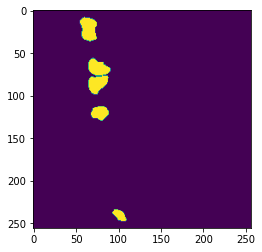

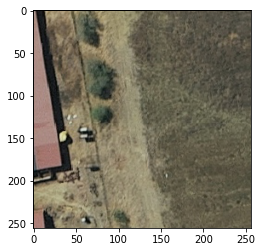

In [6]:
# visualize single patch
print("Single Patch:")
show(patches_labels[0])
show(patches_satellite[0]);

## 1.3.1 Reshape Patches to Fit to the Model

In [7]:
X = np.array(patches_satellite)/255
y = np.array(patches_labels)

## 1.3.2 Feature Scaling & Data Correction

#### Create Training and Test Dataset

In [8]:
from sklearn.model_selection import train_test_split
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=val_ratio, random_state=seed)

# 2. UNet 


In [9]:
from pytorch_segmentation.dataset import InMemorySatDataset
import pytorch_segmentation.augmentation.transforms as seg_transforms

In [10]:
epochs = 30
batch_size = 16
lr = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_dir = "saved_models"

transform = seg_transforms.Compose([
    seg_transforms.RandomHorizontalFlip(0.5),
    seg_transforms.RandomVerticalFlip(0.5),
    #seg_transforms.Normalize(mean=[0.5492, 0.5190, 0.4393],
#                                          std=[0.1381, 0.1320, 0.1349]) #for padded
    seg_transforms.ColorJitter(brightness=0.2)
])

test_transform = None
#test_transform = seg_transforms.Normalize(mean=[0.5492, 0.5190, 0.4393],
#                                          std=[0.1381, 0.1320, 0.1349])


In [11]:

train_dataset = InMemorySatDataset(X_train,y_train,transform=transform)
val_dataset = InMemorySatDataset(X_val,y_val,transform=test_transform)
test_dataset = InMemorySatDataset(X_test,y_test,transform=test_transform)

train_dl = DataLoader(train_dataset,batch_size=batch_size,num_workers=nworkers)
val_dl = DataLoader(val_dataset,batch_size=batch_size,num_workers=nworkers)

## 2.1. Simple Unet
https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705

In [12]:
from pytorch_segmentation.models.unet_simple import UNet
from pytorch_segmentation.train_net import train
import time


In [13]:
net = UNet(3,2)
net = net.to(device)


In [27]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(),lr=lr)
train_loss,valid_loss = train(net,train_dl,val_dl,loss_fn,opt,epochs,device,seed)
torch.save(net.state_dict(), save_dir+"/unet_simple"+str(time.strftime("%d_%m_%Y_%H%M%S"))+".pth")

Epoch 0/29
----------
train Loss: 0.6570 Acc: 0.8107157349586487
valid Loss: 0.6790 Acc: 0.7375543713569641
Epoch 1/29
----------
train Loss: 0.6541 Acc: 0.8287156820297241
valid Loss: 0.6492 Acc: 0.8458302617073059
Epoch 2/29
----------
train Loss: 0.6519 Acc: 0.8410750031471252
valid Loss: 0.6460 Acc: 0.8598350286483765
Epoch 3/29
----------
train Loss: 0.6497 Acc: 0.8499096632003784
valid Loss: 0.6440 Acc: 0.868279755115509
Epoch 4/29
----------
train Loss: 0.6475 Acc: 0.8576058745384216
valid Loss: 0.6417 Acc: 0.8748457431793213
Epoch 5/29
----------
train Loss: 0.6453 Acc: 0.8644675612449646
valid Loss: 0.6398 Acc: 0.879226565361023
Epoch 6/29
----------
train Loss: 0.6433 Acc: 0.8697854280471802
valid Loss: 0.6385 Acc: 0.8822566270828247
Epoch 7/29
----------
train Loss: 0.6415 Acc: 0.8730148673057556
valid Loss: 0.6371 Acc: 0.8836456537246704
Epoch 8/29
----------
train Loss: 0.6398 Acc: 0.8749878406524658
valid Loss: 0.6355 Acc: 0.8845229744911194
Epoch 9/29
----------
train Lo

KeyboardInterrupt: 

## 2.2 Advanced Unet 
https://github.com/milesial/Pytorch-UNet

In [14]:
from pytorch_segmentation.train_net import train
from pytorch_segmentation.models import UNet

In [15]:

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
net = UNet(n_channels=3, n_classes=2, bilinear=False)
net = net.to(device=device)


In [16]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

In [17]:
train_loss,valid_loss = train(net,train_dl,val_dl,loss_fn,opt,epochs,scheduler=scheduler,metric_fn=None,device=device,seed=seed)
torch.save(net.state_dict(), save_dir+"/unet_"+str(time.strftime("%d_%m_%Y_%H%M%S"))+".pth")

Epoch 0/29
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.4729 Score: 0.13777291774749756
valid Loss: 0.4025 Score: 0.1861807405948639
Epoch 1/29
----------
train Loss: 0.4051 Score: 0.2364506870508194
valid Loss: 0.3661 Score: 0.23463955521583557
Epoch 2/29
----------
train Loss: 0.3525 Score: 0.27807071805000305
valid Loss: 0.3131 Score: 0.28084635734558105
Epoch 3/29
----------
train Loss: 0.3113 Score: 0.3152976334095001
valid Loss: 0.2810 Score: 0.3278118371963501
Epoch 4/29
----------
train Loss: 0.2843 Score: 0.35459741950035095
valid Loss: 0.2607 Score: 0.21692827343940735
Epoch 5/29
----------
train Loss: 0.2649 Score: 0.3789043426513672
valid Loss: 0.2511 Score: 0.31989407539367676
Epoch 6/29
----------
train Loss: 0.2516 Score: 0.39140793681144714
valid Loss: 0.2389 Score: 0.3532331883907318
Epoch 7/29
----------
train Loss: 0.2405 Score: 0.4044535458087921
valid Loss: 0.2313 Score: 0.3623603880405426
Epoch 8/29
----------
train Loss: 0.2316 Score: 0.4031514823436737
valid Loss: 0.2259 Score: 0.40778833627700806
Epoch

In [ ]:
# train_net(net=net,
#           datasets=[train_dataset,val_dataset],
#           save_dir = save_dir,
#           epochs=epochs,
#           batch_size=batch_size,
#           save_checkpoint=False,
#           learning_rate=lr,
#           device=device,
#           amp=amp)

## 2.3 Validation

In [18]:
net.eval();

Evaluation based on test dataset

In [29]:
net = net
out = net(test_dataset[8]["x"].unsqueeze(0).to(device))

In [30]:
img = F.softmax(out,dim=1)
img = torch.argmax(img,dim=1)
img = img.cpu().numpy()


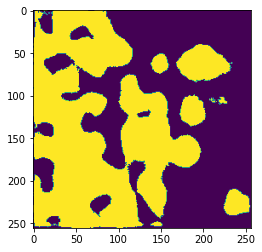

<AxesSubplot:>

In [31]:
show(img)

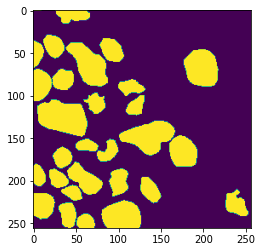

In [28]:
test_dataset.get_mask(8)

In [28]:
net = net
out = net(train_dataset[697]["x"].unsqueeze(0).to(device))

In [29]:
img = F.softmax(out,dim=1)
img = torch.argmax(img,dim=1)
img = img.cpu().numpy()


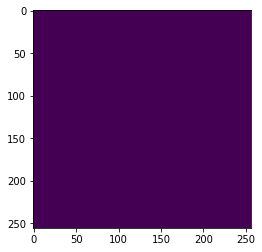

<AxesSubplot:>

In [30]:
show(img)

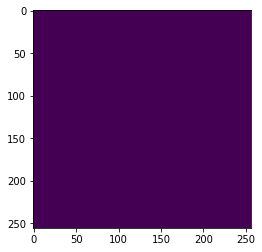

In [31]:
train_dataset.get_mask(697)

521


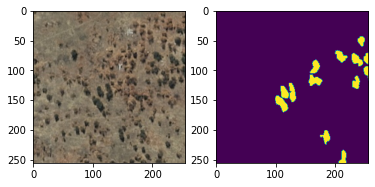

727


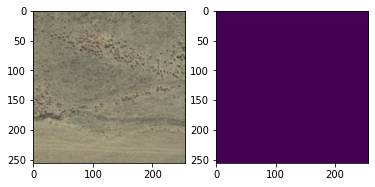

599


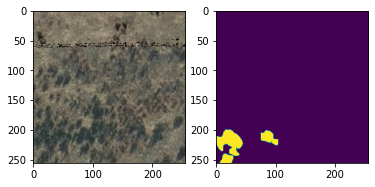

38


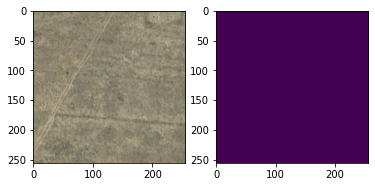

249


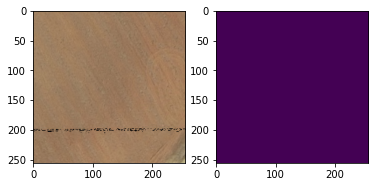

405


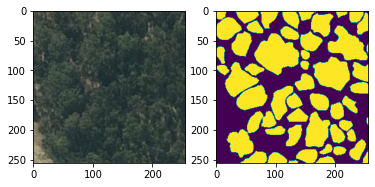

146


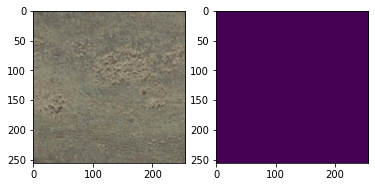

657


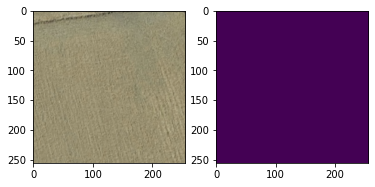

608


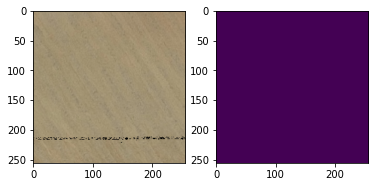

752


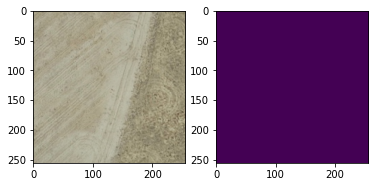

646


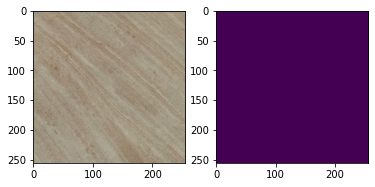

296


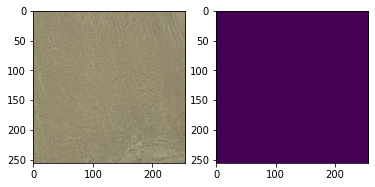

573


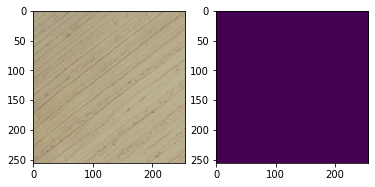

182


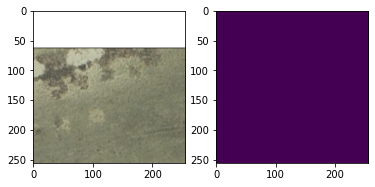

472


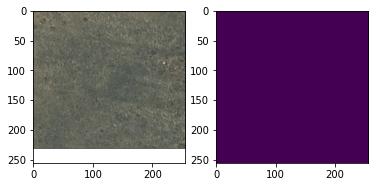

385


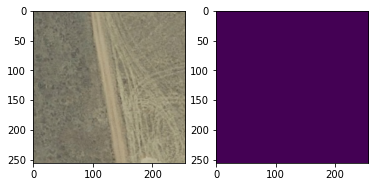

537


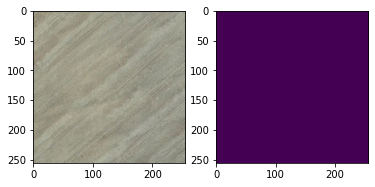

470


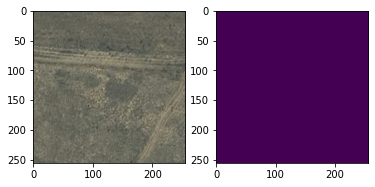

27


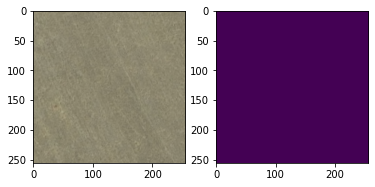

267


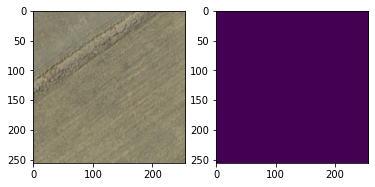

176


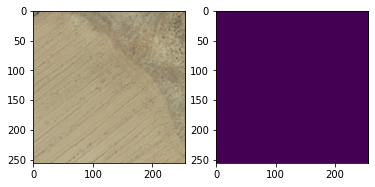

305


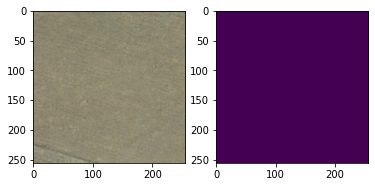

493


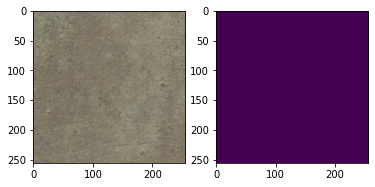

565


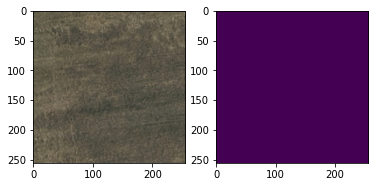

145


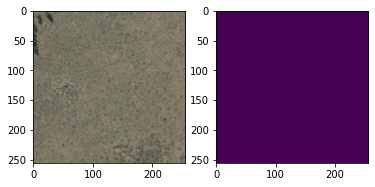

567


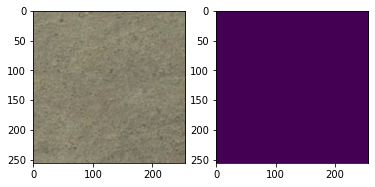

286


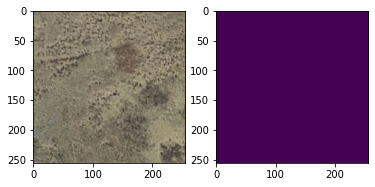

351


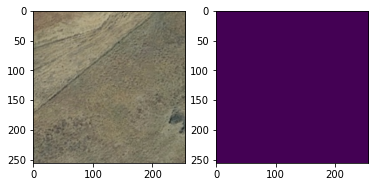

304


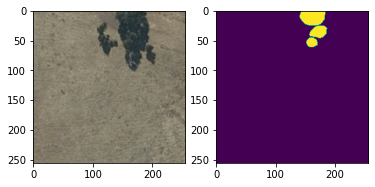

540


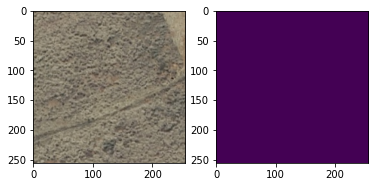

In [32]:
plt.figure()

for i in np.random.choice(range(len(train_dataset)),size=30,replace=False):
    print(i)
    plt.subplot(121)
    plt.imshow(train_dataset[i]["x"].permute(1, 2, 0).numpy())
    plt.subplot(122)
    plt.imshow(train_dataset[i]["y"].numpy())
    plt.show()

In [67]:
net = net
out = net(train_dataset[654]["x"].unsqueeze(0).to(device))

In [68]:
img = F.softmax(out,dim=1)
img = torch.argmax(img,dim=1)
img = img.cpu().numpy()


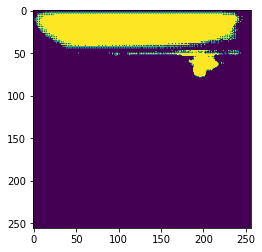

<AxesSubplot:>

In [69]:
show(img)

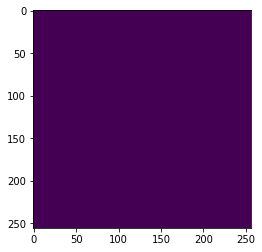

In [70]:
train_dataset.get_mask(654)